In [185]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier

In [135]:
path = "C:/אריאל נושאי לימוד/סמסטר ב/הדמיית נתונים/fmnist/fashion-mnist_train.csv"
data = pd.read_csv(path)

In [136]:
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [137]:
a = data.iloc[0].drop('label').to_numpy()

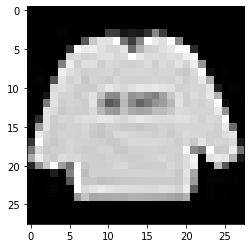

In [138]:
img = a.reshape(28,28)
plt.imshow(img, plt.cm.gray)
plt.show()

In [139]:
from sklearn.model_selection import train_test_split
df = data
x = df.drop(['label'], axis = 1)
y = df.iloc[:, 0]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1,random_state = 42)
print(x_train.shape)

(54000, 784)


## PCA

In [140]:
pca = PCA(n_components = 0.9)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.fit_transform(x_test)

82


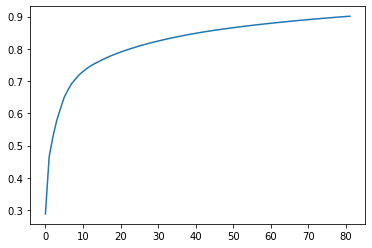

In [141]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
print(pca.n_components_)

In [142]:
scaling_pipeline = Pipeline(
[
    ('std_scaler', StandardScaler()),
    ('PCA',PCA(n_components = 0.9))
])

x_train = scaling_pipeline.fit_transform(x_train)
x_test = scaling_pipeline.transform(x_test)



## RandomForest

In [143]:
model = RandomForestClassifier(n_estimators = 100, random_state = 2, n_jobs = -1)
model.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=2)

In [144]:
pred = model.predict(x_test)
model.score(x_test,y_test)

0.8723333333333333

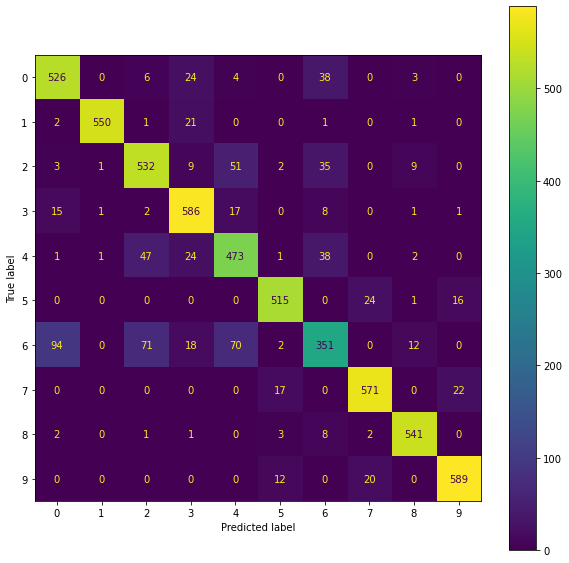

In [195]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(10,10)
plot_confusion_matrix(model,x_test,y_test,ax=ax)

In [146]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       601
           1       0.99      0.95      0.97       576
           2       0.81      0.83      0.82       642
           3       0.86      0.93      0.89       631
           4       0.77      0.81      0.79       587
           5       0.93      0.93      0.93       556
           6       0.73      0.57      0.64       618
           7       0.93      0.94      0.93       610
           8       0.95      0.97      0.96       558
           9       0.94      0.95      0.94       621

    accuracy                           0.87      6000
   macro avg       0.87      0.87      0.87      6000
weighted avg       0.87      0.87      0.87      6000



### Tuning

In [152]:
forest_params = {
    'n_estimators':[100,200,300],
    'max_depth':[20,40,60],
    'max_features':['auto','sqrt','log']
}
rnd_grid_search = RandomizedSearchCV(RandomForestClassifier(),
                                    forest_params,
                                     n_jobs = -1,
                                     n_iter = 3,
                                     scoring = 'accuracy',
                                     return_train_score = True
                                    )

rnd_grid_search.fit(x_train,y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=3, n_jobs=-1,
                   param_distributions={'max_depth': [20, 40, 60],
                                        'max_features': ['auto', 'sqrt', 'log'],
                                        'n_estimators': [100, 200, 300]},
                   return_train_score=True, scoring='accuracy')

In [155]:
rnd_grid_search.best_estimator_

RandomForestClassifier(max_depth=60, max_features='sqrt', n_estimators=200)

In [156]:
rnd_grid_search.best_score_

0.8663333333333334

## KNN

In [180]:
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)
knn.score(x_test,y_test)

0.8653333333333333

## XGBOOST

In [159]:
xgb = XGBClassifier(n_jobs = -1)
xgb.fit(x_train, y_train)

xgb.score(x_test,y_test)

[14:31:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.889

### Tuning

In [165]:
xgb_params = {
    'n_estimators': [100,200],
    'max_depth': [3,6,9],
    'learning_rate': [0.01,0.1]
    
}
xgb_rnd_grid_search = RandomizedSearchCV(XGBClassifier(),
                                        xgb_params,
                                        n_jobs = -1,
                                         n_iter = 1,
                                        scoring = 'accuracy',
                                        return_train_score = True)

xgb_rnd_grid_search.fit(x_train,y_train)

C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:27:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lamb

In [166]:
xgb_rnd_grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [167]:
xgb_rnd_grid_search.best_score_

0.8236851851851853

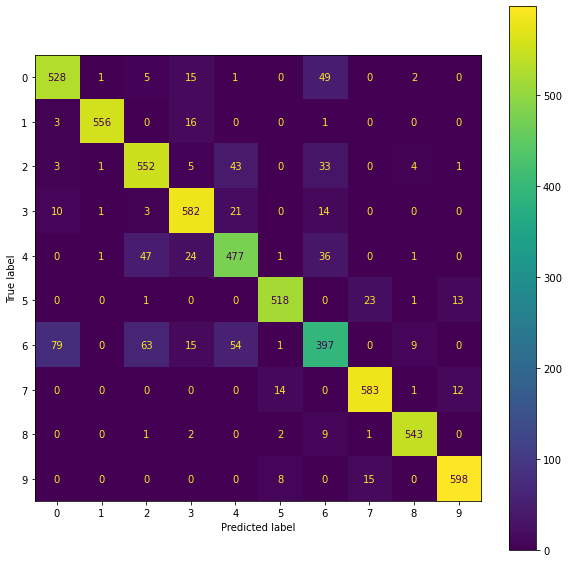

In [194]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(10,10)
plot_confusion_matrix(xgb,x_test,y_test,ax=ax)

In [171]:
print(xgb.score(x_test,y_test))

print(classification_report(xgb.predict(x_test),y_test))

0.889
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       623
           1       0.97      0.99      0.98       560
           2       0.86      0.82      0.84       672
           3       0.92      0.88      0.90       659
           4       0.81      0.80      0.81       596
           5       0.93      0.95      0.94       544
           6       0.64      0.74      0.69       539
           7       0.96      0.94      0.95       622
           8       0.97      0.97      0.97       561
           9       0.96      0.96      0.96       624

    accuracy                           0.89      6000
   macro avg       0.89      0.89      0.89      6000
weighted avg       0.89      0.89      0.89      6000



## Voting

In [182]:
voting_clf = VotingClassifier(
    estimators=[('knn',knn),('rnd_forrest',model),('xgb',xgb)],
    voting = 'soft',
    weights=[1,2,4],
    n_jobs=-1
)
voting_clf.fit(x_train,y_train)

VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_jobs=-1)),
                             ('rnd_forrest',
                              RandomForestClassifier(n_jobs=-1,
                                                     random_state=2)),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_delta_step=0, max_depth=6,
                                            min_child_weight=1, missing=nan,
                                            monotone_const

In [183]:
voting_clf.score(x_test,y_test)

0.8906666666666667

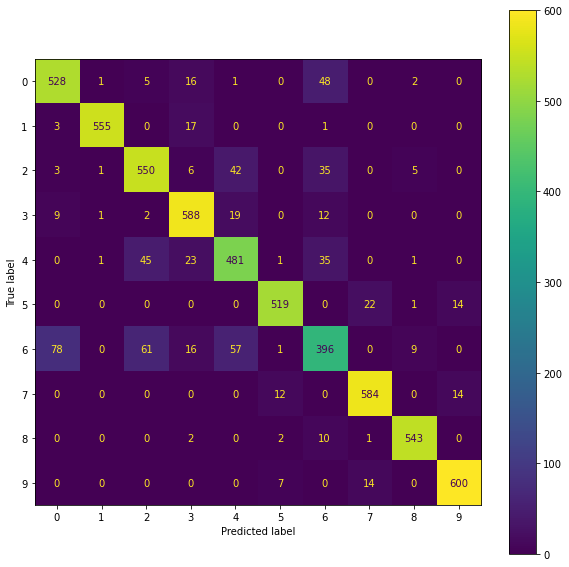

In [196]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(10,10)
plot_confusion_matrix(voting_clf,x_test,y_test,ax=ax)

### The best model was the voting calssifier using knn,random forest and XGBoost with 89% 